## 1. VHM Dataset

In [91]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [92]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1-VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [93]:
df1

0       68421.0
1       70075.0
2       68421.0
3       69022.0
4       69173.0
         ...   
1247    43350.0
1248    44200.0
1249    44400.0
1250    43400.0
1251    43950.0
Name: Price, Length: 1252, dtype: float64

In [94]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [95]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [96]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [97]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [98]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [99]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.1155 - val_loss: 0.0018
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0149 - val_loss: 0.0014
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 11

In [100]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


In [101]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [102]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 43402.193280135245
Testing MAPE: 541459.2348366167
Testing MAE: 43394.89149307766


In [103]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


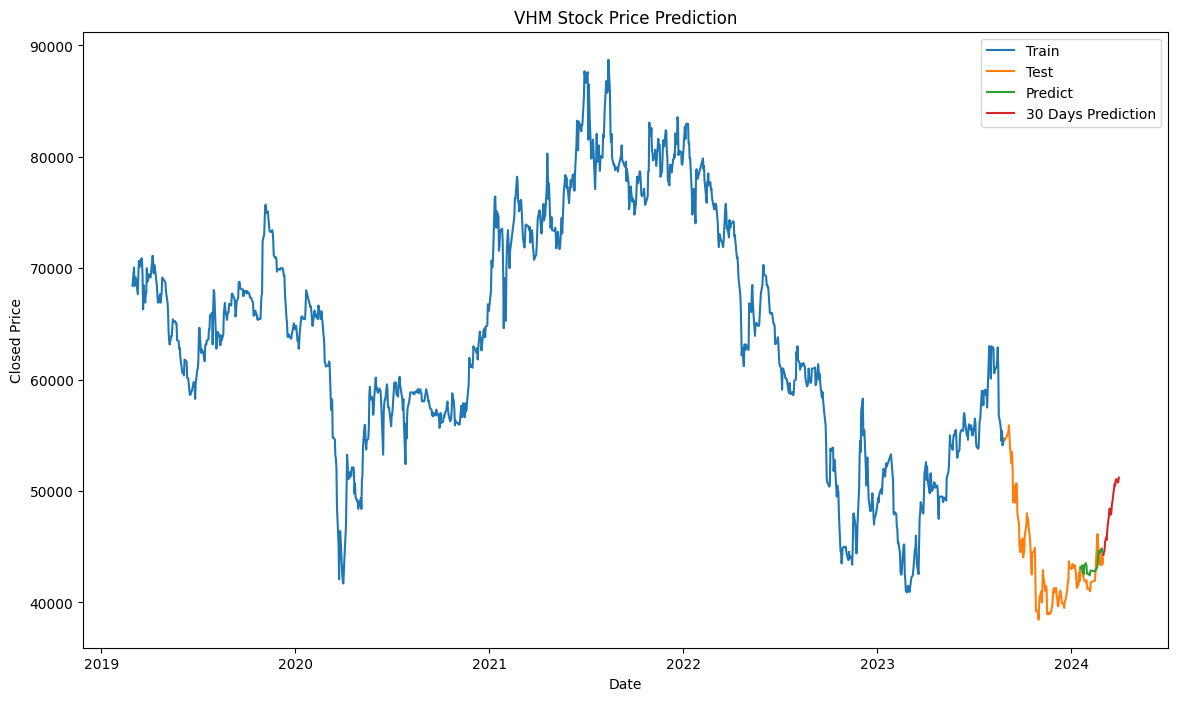

In [104]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## 2. NVL Dataset

In [105]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [106]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2-NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [107]:
df1

0       32933.0
1       33100.0
2       32711.0
3       31709.0
4       31932.0
         ...   
1247    16800.0
1248    17050.0
1249    17000.0
1250    17100.0
1251    17300.0
Name: Price, Length: 1252, dtype: float64

In [108]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [109]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [110]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [111]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [112]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [113]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.0281 - val_loss: 3.1902e-04
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 7.0974e-05
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 1.0044e-04
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 1.9923e-04
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 8.7128e-05
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 1.1819e-04
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 5.3858e-05
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 5.5316e-05
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.4967e-05
Epoch 10/100
17/17 [==============================] - 0s 4ms/step - loss

In [114]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [115]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [116]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 16531.106547485797
Testing MAPE: 201828.62856112848
Testing MAE: 16522.244561614818


In [117]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


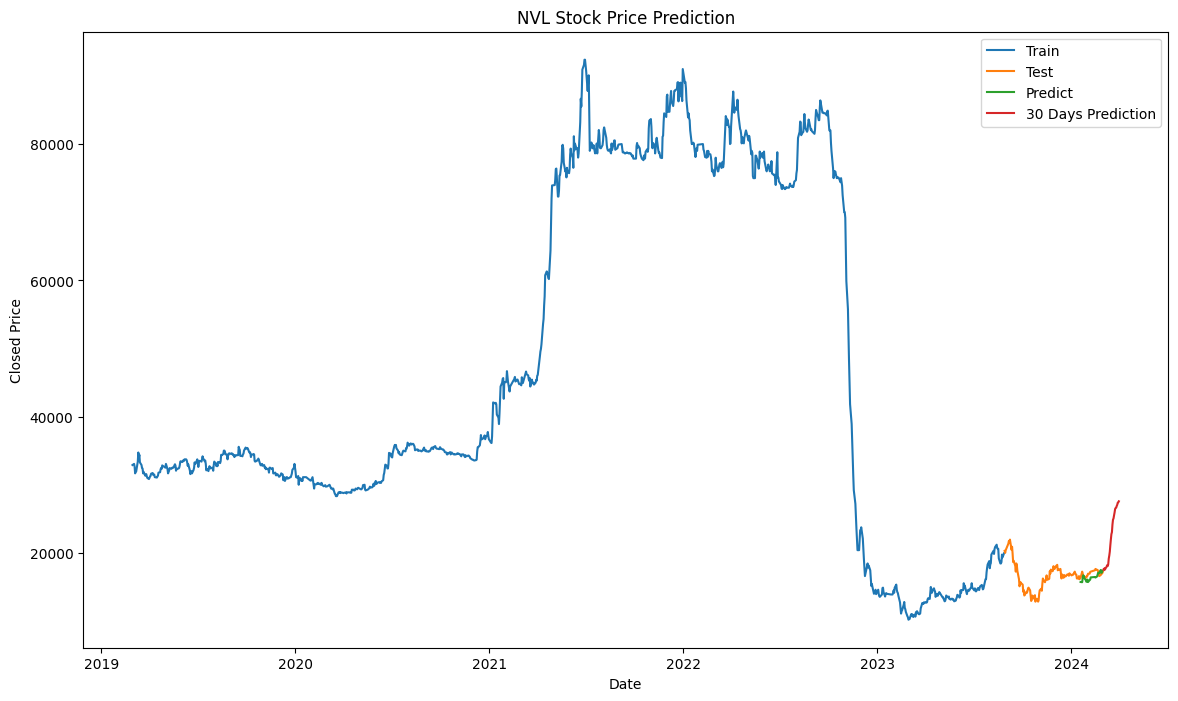

In [118]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## 3. NLG Dataset

In [119]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [120]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3-NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [121]:
df1

0       18706.8
1       19127.2
2       18917.0
3       18846.9
4       18706.8
         ...   
1247    37400.0
1248    38500.0
1249    38200.0
1250    39600.0
1251    39900.0
Name: Price, Length: 1252, dtype: float64

In [122]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [123]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [124]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [125]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [126]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [127]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 11ms/step - loss: 0.0989 - val_loss: 0.0479
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0122
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 9.6562e-04
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 9.2217e-04
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 8.0747e-04
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 10/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0

In [128]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [129]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [130]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 39471.44101485848
Testing MAPE: 79397.65659606081
Testing MAE: 39464.56627782786


In [131]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


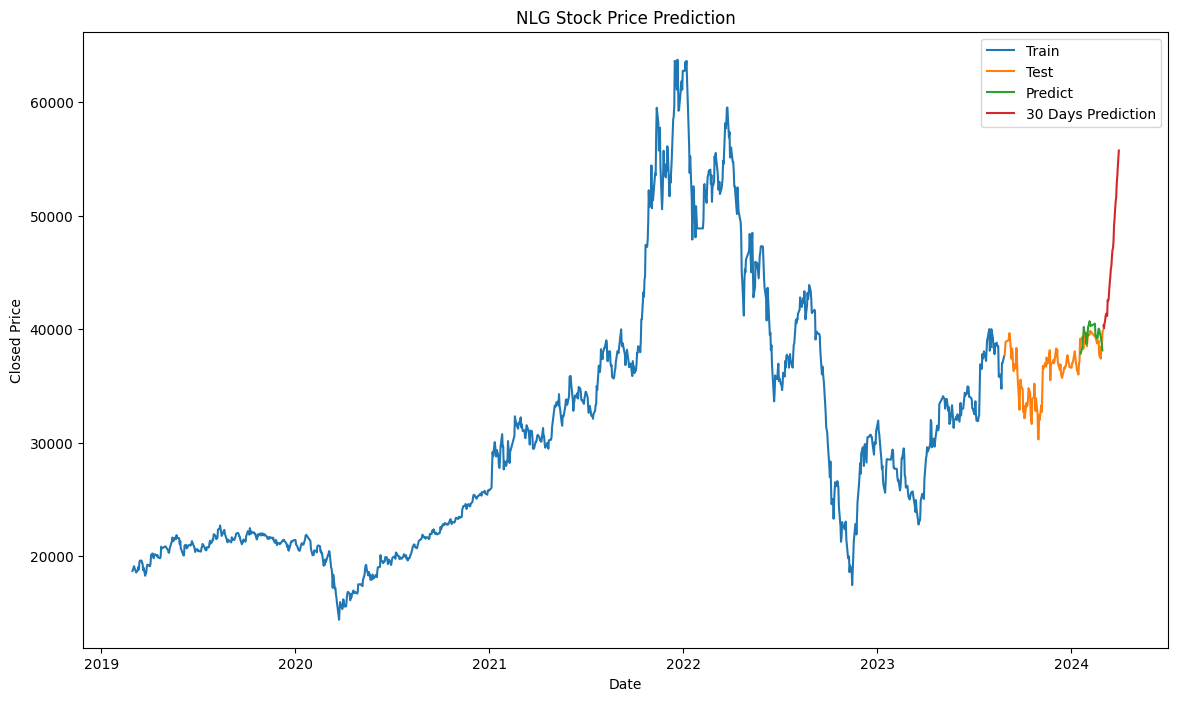

In [132]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()